In [1]:
import os
os.environ['OMP_NUM_THREADS']='32'
# os.environ['MKL_NUM_THREADS']='32'

In [2]:
import numpy as np
import pandas as pd
import subprocess
import time
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy
import sys

from rdkit import Chem
from rdkit.Chem import AllChem
import ase
from ase.io import read, write
from ase.units import Hartree
from ase.visualize import view

from ase.io.trajectory import Trajectory
import glob
import pickle

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

from photocatalysis.learners_treesearch import get_population_completed

In [3]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

In [4]:
### LOCAL
# local_path = os.path.join('/home/scakolli/Thesis/photocatalysis/workspace', 'DF_COMPLETE.json')
# df = pd.read_json(local_path, orient='split')

### REMOTE
df = pd.read_json('/home/btpq/bt308495/Thesis/frames/DF_COMPLETE.json', orient='split')

In [5]:
print("Fizzled / Total")
print("{} / {}".format(df.loc[df.calc_status == 'fizzled'].shape[0], df.shape[0]))

Fizzled / Total
1410 / 65552


In [6]:
# Get succesfully completed
df = get_population_completed(df)

---

In [ ]:
from photocatalysis.cheminformatics_fingerprint import get_tanimoto_distmat, get_tanimoto_distmat_multiprocessing
from photocatalysis.gpr_model import GPR_tanimoto
from photocatalysis.learners_treesearch import generate_ml_vectors


In [ ]:
df = generate_ml_vectors(df)

In [ ]:
X = df.morgan_fp_bitvect.values.tolist()

In [ ]:
n = 6000
X1 = X.copy()[:n]
Y1 = df.IP.values.copy()[:n]

In [ ]:
gpr_test_sp = GPR_tanimoto(multiprocess=1, D_scratch_dir='/localdisk/bt308495/testing')

In [ ]:
gpr_test_sp.fit(X1, Y1)

In [ ]:
y_sp = gpr_test_sp.predict(X1)

In [ ]:
gpr_test_mp = GPR_tanimoto(multiprocess=16, D_scratch_dir='/localdisk/bt308495/testing_mp')

In [ ]:
gpr_test_mp.fit(X1, Y1)

In [ ]:
y1_mp = gpr_test_mp.predict(X1)

----

# ML

In [7]:
from photocatalysis.learners_treesearch import ML_model, generate_ml_vectors
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, PredictionErrorDisplay

In [8]:
scratch_dir = '/localdisk/bt308495/'
scratch_fname = 'scratch_distance_matrix_80_20'

# Load Models
with open(os.path.join(scratch_dir, 'ML_IP_70_30.pckl'), 'rb') as f:
    df_training, df_test, kip = pickle.load(f)

with open(os.path.join(scratch_dir,'ML_dGmax_70_30.pckl'), 'rb') as f:
    _, _, krdg = pickle.load(f)

df_test = generate_ml_vectors(df_test)


In [14]:
X_test = df_test.morgan_fp_bitvect.values
y_test_rdg, y_test_pred_rdgy_test_ip = df_test.IP.values

In [ ]:
gpr_ip = ML_model(df_training, 'IP', kip, multiprocess=16, D_scratch_dir=os.path.join(scratch_dir, scratch_fname))

In [ ]:
# Save
# with open(os.path.join(scratch_dir, 'gpr_ip_70_30.pckl'), 'wb') as f:
#     pickle.dump(gpr_ip, f)

# Load
with open(os.path.join(scratch_dir, 'gpr_ip_70_30.pckl'), 'rb') as f:
    gpr_ip = pickle.load(f)

In [ ]:
# y_test_pred_ip, std_test_pred_ip = gpr_ip.predict(X_test, return_std=True) **** SLOW (70mins)
y_test_pred_ip = gpr_ip.predict(X_test)

In [ ]:
mae_ip = mean_absolute_error(y_test_ip, y_test_pred_ip) # mae
evs_ip = explained_variance_score(y_test_ip, y_test_pred_ip) # explained variance
r2_ip = r2_score(y_test_ip, y_test_pred_ip) # pearson r2 score

In [ ]:
print(r2_ip)

In [ ]:
display = PredictionErrorDisplay(y_true=y_test_ip, y_pred=y_test_pred_ip)
display.plot()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test_ip, y_test_pred_ip, label='IP', alpha=0.7)
ax.plot(y_test_ip, y_test_ip, 'k')
ax.set_xlabel('True')
ax.set_ylabel('Predicted')

In [ ]:
# D = np.load('/localdisk/bt308495/D.npy')

In [ ]:
# plt.title('Normalized model uncertainty, $\sigma / \sigma_{population}$ ')
# plt.hist(std_test_pred_ip/np.nanstd(df_test.IP.values), label='IP', density=True, bins=20)
# # plt.hist(stdrdg/np.nanstd(main_frame.dGmax.values), label='dGmax', density=True)
# plt.legend()

RDG

In [13]:
X_test = df_test.morgan_fp_bitvect.values
y_test_rdg = df_test.dGmax.values

In [9]:
gpr_rdg = ML_model(df_training, 'dGmax', krdg, multiprocess=16, D_scratch_dir=os.path.join(scratch_dir, scratch_fname))

Number of cores to be used: 1
######### Fitting GPR Model #########
Reading distance matrix
Constructing kernel
Cholesky decomposition
Cholesky inverse triangular solve
######### Finished Fitting GPR Model. Took 5.034250343365906 mins #########


In [12]:
y_test_pred_rdg = gpr_rdg.predict(X_test)

######### Predicting GPR Model #########
Reading distance matrix
Constructing kernel
ystar
######### Finished Predicting GPR Model. Took 0.8814074849331519 mins #########


Text(0, 0.5, 'Predicted')

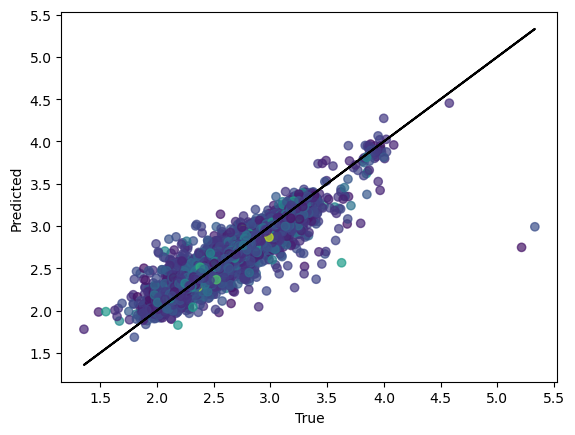

In [58]:
fig, ax = plt.subplots()
ax.scatter(y_test_rdg, y_test_pred_rdg, label='IP', alpha=0.7, c=D_test_sorted_mean)
ax.plot(y_test_rdg, y_test_rdg, 'k')
ax.set_xlabel('True')
ax.set_ylabel('Predicted')

In [59]:
df

,molecule_smiles,operation,molecule_last_gen,generation,IP,dGmax,symmetry,added_in_round,calc_status,morgan_fp_bitvect,finished_in_round,utility_function
0,c1ccccc1,none,c1ccccc1,0,2.9277,2.917136,True,0,completed,{},0,0.010564
1,c1ccc(-c2ccccc2)cc1,"[cH&r6,CH&r5:1]>>[#6:1](-[c]1[ch]ccc[ch]1)",c1ccccc1,1,2.1982,2.897454,True,1,completed,{},1,-0.699254
2,c1ccc2ccccc2c1,[cH&r6:1][cH&r6:2]>>[c:1]2cccc[c:2]2,c1ccccc1,1,1.9595,2.937996,True,1,completed,{},1,-0.978496
3,C1=CCC=C1,[c:0]1[ch:1][ch][c:3][c!r5:4][c!r5:5]1>>[c:0]1...,c1ccccc1,1,2.1231,3.019702,True,1,completed,{},1,-0.896602
4,C(=Cc1ccccc1)c1ccccc1,"[ch&r6,CH1&r5:1]>>[*:1](-C=C-c1ccccc1)",c1ccccc1,1,1.6129,3.317615,True,1,completed,{},1,-1.704715
...,...,...,...,...,...,...,...,...,...,...,...,...
315050,C1=CC(=C2Nc3cc4cnoc4cc3N2)C=C1,"[chr5,CH1r5:1]>>[n:1]",C1=CC(=C2Nc3cc4ccoc4cc3N2)C=C1,14,0.8816,2.550215,True,14,completed,{},14,-1.668615
315063,C1=CC(=C2Nc3ccc4nscc4c3N2)C=C1,"[chr5,CH1r5:1]>>[n:1]",C1=CC(=C2Nc3ccc4cscc4c3N2)C=C1,14,0.6107,2.332208,True,14,completed,{},14,-1.721508
315100,C1=CC(=C2Nc3cc4c[nH]cc4cc3N2)C=N1,"[chr5,CH1r5:1]>>[n:1]",C1=CC(=C2Nc3cc4c[nH]cc4cc3N2)C=C1,14,0.6928,2.612220,True,14,completed,{},14,-1.919420
315106,C1=CC(=C2Nc3ccc4n[nH]cc4c3N2)C=C1,"[chr5,CH1r5:1]>>[n:1]",C1=CC(=C2Nc3ccc4c[nH]cc4c3N2)C=C1,14,0.5327,2.615735,True,14,completed,{},14,-2.083035


In [36]:
from photocatalysis.cheminformatics_fingerprint import get_tanimoto_distmat, get_tanimoto_distmat_multiprocessing

In [22]:
resid = y_test_pred_rdg - y_test_rdg
indx = np.argsort(resid)

In [37]:
X_test_sorted = X_test[indx].copy()
D_test_sorted = get_tanimoto_distmat(X_test_sorted, X_test_sorted)

100%|██████████| 19243/19243 [09:23<00:00, 34.16it/s]


In [38]:
D_test_sorted_mean = D_test_sorted.mean(axis=1)

(array([[1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 2.2650e+03, 1.4143e+04,
         2.6140e+03],
        [1.0000e+00, 0.0000e+00, 3.0000e+00, ..., 3.7240e+03, 1.4620e+04,
         2.0600e+02],
        [1.0000e+00, 0.0000e+00, 1.5000e+01, ..., 4.5430e+03, 1.1670e+04,
         1.2230e+03],
        ...,
        [1.0000e+00, 0.0000e+00, 3.0000e+00, ..., 4.4740e+03, 1.3528e+04,
         3.9100e+02],
        [1.0000e+00, 0.0000e+00, 2.0000e+00, ..., 4.8570e+03, 1.3532e+04,
         2.0400e+02],
        [1.0000e+00, 2.0000e+00, 1.3000e+01, ..., 4.0600e+03, 1.1519e+04,
         1.3730e+03]]),
 array([0.        , 0.0980198 , 0.1960396 , 0.29405941, 0.39207921,
        0.49009901, 0.58811881, 0.68613861, 0.78415842, 0.88217822,
        0.98019802]),
 <a list of 19243 BarContainer objects>)

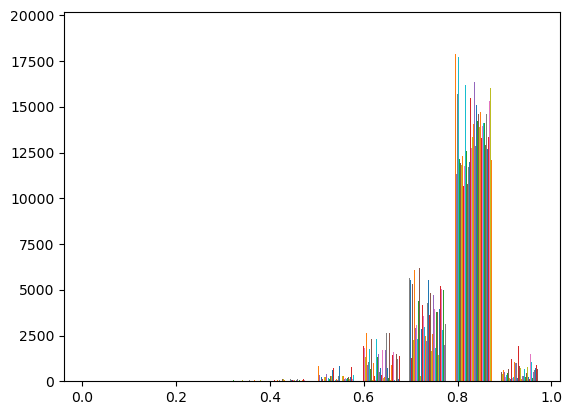

In [60]:
plt.hist(D_test_sorted, bins=20)

In [16]:
mae_rdg = mean_absolute_error(y_test_rdg, y_test_pred_rdg) # mae
evs_rdg = explained_variance_score(y_test_rdg, y_test_pred_rdg) # explained variance
r2_rdg = r2_score(y_test_rdg, y_test_pred_rdg) # pearson r2 score

In [47]:
r2_rdg

0.9130008569196497

---

### Fitting GPR using gpr_model.py

In [ ]:
from photocatalysis.learners_treesearch import generate_ml_vectors
from sklearn.model_selection import train_test_split

from scipy.linalg import cholesky, cho_solve, solve_triangular

In [ ]:
df = generate_ml_vectors(df)
df_training, df_test = train_test_split(df, test_size=0.3, random_state=42)

X_train = df_training.morgan_fp_bitvect.values
y_train = df_training.IP.values

In [ ]:
# Prep data
_y_train_mean = np.mean(y_train, axis=0)
_y_train_std = np.std(y_train, axis=0)
y_train = (y_train - _y_train_mean) / _y_train_std
y_train = np.array(y_train, ndmin=2).T

In [ ]:
kernel_params = {'C':1., 'length_scale':1., 'sigma_n':0.1}

In [ ]:
#### 1m3s (16 core)
#### 59s (42 core)
# Load distance matrix
D = np.load('/localdisk/bt308495/scratch_distance_matrix_80_20/D_mat.npy')

# construct kernel with noise
white_noise = np.eye(len(X_train),len(X_train)) * kernel_params['sigma_n']**2
K = kernel_params['C']**2*(1.-D)
K += white_noise

# Cholesky decomposition
L = cholesky(K, lower=True)

In [ ]:
### 1m28s (16 core)
### 1m5s (42 core)
alpha = cho_solve((L, True), y_train)
L_inv = solve_triangular(L.T, np.eye(L.shape[0]))

In [ ]:
# np.save('/localdisk/bt308495/D.npy', D)
# np.save('/localdisk/bt308495/K.npy', K)
# np.save('/localdisk/bt308495/L.npy', L)
# np.save('/localdisk/bt308495/L_inv.npy', L_inv)

D = np.load('/localdisk/bt308495/D.npy')
K = np.load('/localdisk/bt308495/K.npy')
L = np.load('/localdisk/bt308495/L.npy')
L_inv = np.load('/localdisk/bt308495/L_inv.npy')

In [ ]:
alpha = cho_solve((L, True), y_train)

In [ ]:
K_gradient = np.dstack(( (np.full((K.shape[0], K.shape[1]), 2*kernel_params['C'],
                            dtype=np.array(kernel_params['C']).dtype)*K)[:, :, np.newaxis],
                           ( kernel_params['C']**2* np.zeros(K.shape) )[:, :, np.newaxis], 
                           (np.eye(len(X_train), len(X_train)) * 2*kernel_params['sigma_n'])[:, :, np.newaxis]
                        ))

In [ ]:
### 1m53s (32 core)
### 1m45.7 (42 core)
L_inv_T = L_inv.copy().T
K_inv = L_inv.dot(L_inv_T)

In [ ]:
print('Log Marginal Likehood determination')
log_likelihood_dims = -0.5 * np.einsum("ik,ik->k", y_train, alpha)
log_likelihood_dims -= np.log(np.diag(L)).sum()
log_likelihood_dims -= len(X_train) / 2 * np.log(2 * np.pi)
log_likelihood = log_likelihood_dims.sum(-1)  # sum over dimensions


tmp = np.einsum("ik,jk->ijk", alpha, alpha)  # k: output-dimension
tmp -= cho_solve((L, True), np.eye(len(X_train)))[:, :, np.newaxis]

In [ ]:
log_likelihood_gradient_dims = 0.5 * np.einsum("ijl,jik->kl", tmp, K_gradient)
log_likelihood_gradient = log_likelihood_gradient_dims.sum(-1)
output = float(log_likelihood), log_likelihood_gradient

------

# GPR MODEL

In [ ]:
test_size = 0.95
random_state = 42

In [ ]:
from photocatalysis.learners_treesearch import generate_ml_vectors, get_ML_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

In [ ]:
### With np.arrays()
# X = generate_ml_vectors(df).morgan_fp_bitvect.values

# Y_IP = df.IP.values
# Y_dGmax = df.dGmax.values

# X_train_IP, X_test_IP, y_train_IP, y_test_IP = train_test_split(X, Y_IP, test_size=test_size, random_state=random_state)
# X_train_dGmax, X_test_dGmax, y_train_dGmax, y_test_dGmax = train_test_split(X, Y_dGmax, test_size=test_size, random_state=random_state)

In [ ]:
### With pd.DataFrames()
df_training, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
df_test = generate_ml_vectors(df_test)

In [ ]:
df.plot(y='utility_function', kind='hist', bins=40)

----

In [ ]:
start = time.perf_counter()
gpr_ip, xtrain_ip, kip = get_ML_model(df_training, 'IP', multiprocess=1, D_scratch_dir='/run/user/1308495/scratch_distance_matrix', niter_local=1)
print('IP Fitting Took:', time.perf_counter() - start)

In [ ]:
main_scratch = '/run/user/1308495'
save_path = os.path.join(main_scratch, 'ML_IP_95_1.pckl')

In [ ]:
with open(save_path, 'wb') as p:
    pickle.dump([gpr_ip, xtrain_ip, kip], p)

In [ ]:
with open(save_path, 'rb') as p:
    out = pickle.load(p)

In [ ]:
X_test = df_test.morgan_fp_bitvect.values

In [ ]:
yip, stdip = gpr_ip.predict(X_test, return_std=True)

---

In [ ]:
start = time.perf_counter()
gpr_rdg, xtrain_rdg, krdg = get_ML_model(df_training, 'dGmax', multiprocess=1, D_scratch_dir='/run/user/1308495/scratch_distance_matrix', niter_local=1)
print('RDG Fitting Took:', time.perf_counter() - start)